<a href="https://colab.research.google.com/github/Geektrovert/deep-learning-v2-pytorch/blob/master/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models
import requests
import os

In [0]:
# get features portion of VGG19
vgg = models.vgg19(pretrained=True).features

# freeze the network
for param in vgg.parameters():
  param.requires_grad_(False)

In [0]:
# select appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)
print("Training on ", device)

Training on  cuda


In [0]:
def load_image(img_path, max_size=400, shape=None):
  """
  Load in and transform image, making sure the image
  is <400px in the x-y dims
  """

  # Load image
  if "http" in img_path:
    response = requests.get(img_path)
    image = Image.open(BytesIO(response.content)).convert("RGB")
  else:
    image = Image.open(img_path).convert("RGB")

  # Set size to resize image to
  img_size = max(image.size)
  to_size = max_size if img_size > max_size else img_size # set to max size
  if shape is not None:
    to_size = shape # set to predefined shape

  # settings for transforming the image
  in_transform = transforms.Compose([
                        transforms.Resize(to_size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

  # discard the transparent, alpha channel (that's the :3)
  # and add the batch dimension
  image = in_transform(image)[:3,:,:].unsqueeze(0)

  return image

In [0]:
# clear any pre-downloaded image
!rm -rf *.jpg*
# download the images

# download content image
!wget -O content.jpg https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/style-transfer/images/octopus.jpg
# download style image
!wget -O style.jpg https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1200px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
# show image path
!ls -alh | grep jpg

--2020-02-28 17:42:47--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/style-transfer/images/octopus.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92235 (90K) [image/jpeg]
Saving to: ‘content.jpg’

content.jpg         100%[===================>]  90.07K  --.-KB/s    in 0.002s  

2020-02-28 17:42:48 (41.1 MB/s) - ‘content.jpg’ saved [92235/92235]

--2020-02-28 17:42:51--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1200px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request se

In [0]:
# set the image path
base_dir = os.getcwd()
content_path = os.path.join(base_dir, "content.jpg")
style_path = os.path.join(base_dir, "style.jpg")

# load content image
content = load_image(content_path).to(device)
# load style image and resize to content image size
style = load_image(style_path, shape=content.shape[-2:]).to(device)

# check image size
print("content img size: ", content.shape[-2:])
print("style img size: ", style.shape[-2:])

content img size:  torch.Size([400, 592])
style img size:  torch.Size([400, 592])


In [0]:
# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def tensor_to_img(tensor):
  """ Transform tensor back to img """

  img = tensor.to("cpu").clone().detach()
  img = img.numpy().squeeze()
  img = img.transpose(1, 2, 0)
  img = img * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  img = img.clip(0, 1)

  return img

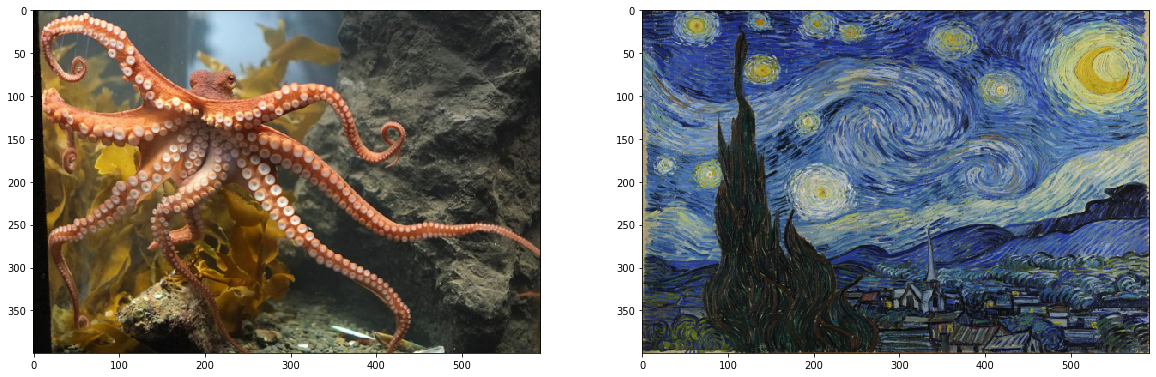

In [0]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(tensor_to_img(content))
ax2.imshow(tensor_to_img(style))

## VGG19 Layers

In [0]:
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# Content and style features

In [0]:
def get_feaatures(img, model, layers=None):
  """ Run an image forward through a model and get the features for
  a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
  """

  if layers is None:
    layers = {"0": "conv1_1",
              "5": "conv2_1",
              "10": "conv3_1",
              "19": "conv4_1",
              "21": "conv4_2",  ## content representation
              "28": "conv5_1",}
    features = {}
    x = img
    # model._modules is a dictionary holding each module in a model
    for name, layer in model._modules.items():
      x = layer(x)
      if name in layers:
        features[layers[name]] = x
    
    return features

## Gram Matrix

In [0]:
def gram_matrix(tensor):
  """ Calculate the Gram Matrix of a given tensor 
      Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
  """

  # get the batch_size, depth, height and weight of a tensor
  _, d, h, w = tensor.size()

  # reshape so we're multiplying the features for each channel
  tensor = tensor.view(d, h* w)

  # calculate the gram matrix
  gram = torch.mm(tensor, tensor.t())

  return gram

# Putting it all together

In [0]:
# get content and style featues only once before training
content_features = get_feaatures(content, vgg)
style_features = get_feaatures(style, vgg)

# calculate the gram matrix for each layer of the style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

# Loss and weights

In [0]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {"conv1_1": 1.00,
                 "conv2_1": 1.00,
                 "conv3_1": 1.00,
                 "conv4_1": 0.50,
                 "conv5_1": 0.20,}
content_weight = 1 # alpha
style_weight = 1e15 # beta

Step:  100 Total loss:  1.6026632669311795e+17


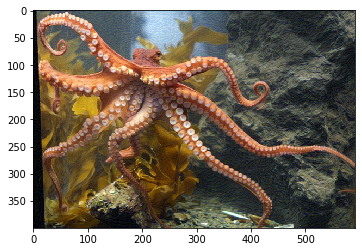

Step:  200 Total loss:  9.824272115145114e+16


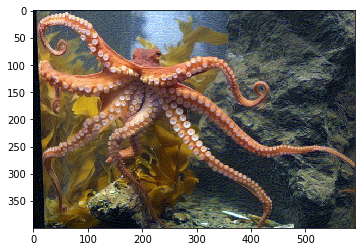

Step:  300 Total loss:  6.488882976443597e+16


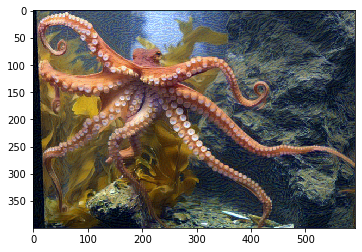

Step:  400 Total loss:  4.110598093878067e+16


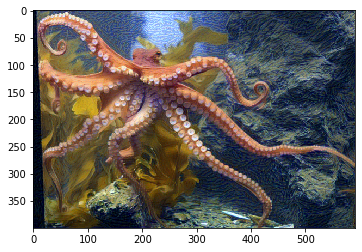

Step:  800 Total loss:  7288884308213760.0


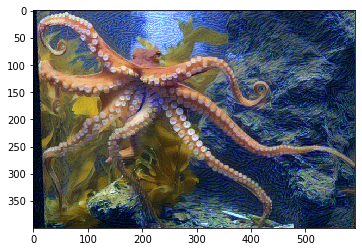

Step:  1200 Total loss:  3774024270217216.0


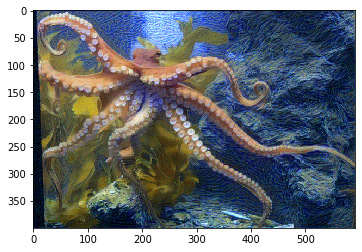

Step:  1600 Total loss:  2311154651103232.0


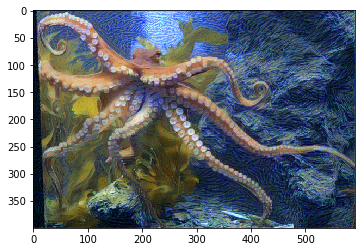

Step:  2000 Total loss:  1500523731615744.0


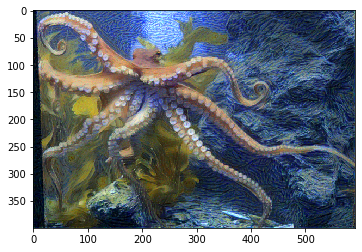

Step:  2400 Total loss:  1026558991007744.0


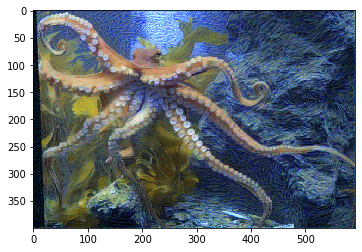

Step:  2800 Total loss:  739025895817216.0


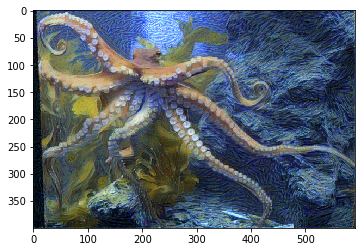

Step:  3200 Total loss:  557437128015872.0


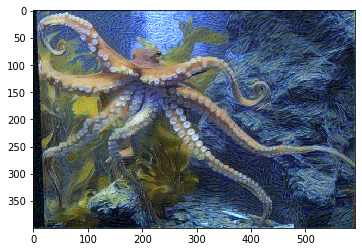

Step:  3600 Total loss:  436149432614912.0


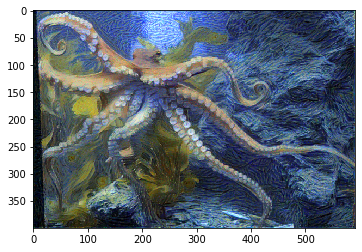

Step:  4000 Total loss:  350302934925312.0


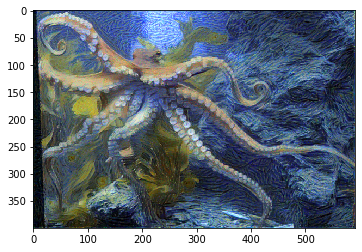

Step:  4400 Total loss:  286691248046080.0


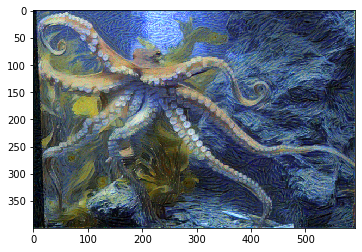

Step:  4800 Total loss:  238084985716736.0


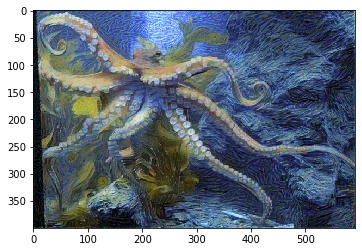

Step:  5200 Total loss:  200393460023296.0


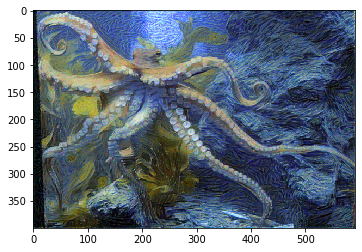

Step:  5600 Total loss:  170824187248640.0


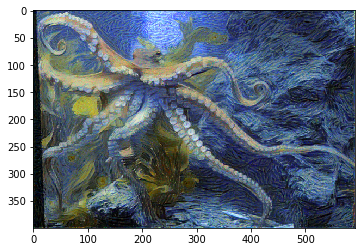

Step:  6000 Total loss:  147325297098752.0


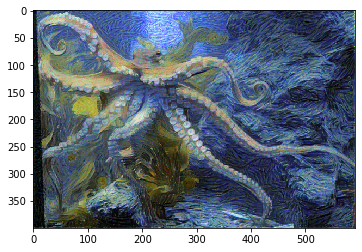

Step:  6400 Total loss:  128525151502336.0


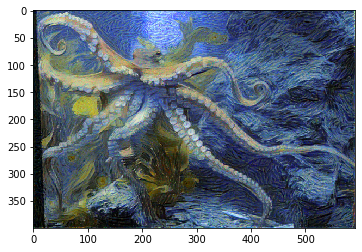

Step:  6800 Total loss:  114031557869568.0


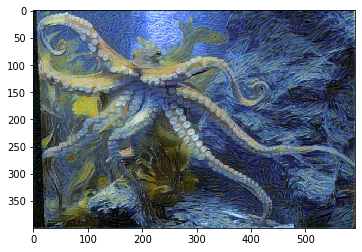

Step:  7200 Total loss:  102521280397312.0


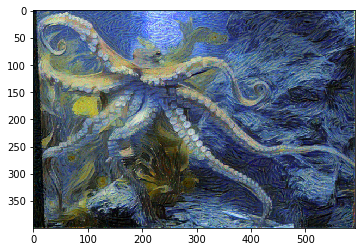

Step:  7600 Total loss:  95800730320896.0


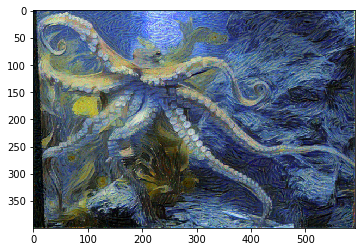

Step:  8000 Total loss:  87858773753856.0


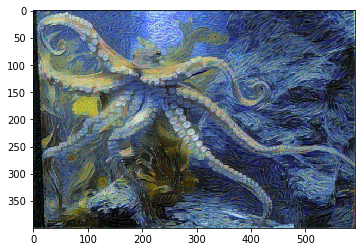

In [0]:
# for displaying the target image, intermittently
show_every_min = 100
show_every_max = 400

# hyper params
optimizer = optim.Adam([target], lr=0.003)
steps = 8000 # determines how many times image will be updated

for step in range(1, steps+1):

  # get features from target image
  target_features = get_feaatures(target, vgg)

  # the content loss
  content_loss = torch.mean((target_features["conv4_2"] - content_features["conv4_2"])**2)

  # the style loss (initialized with 0)
  style_loss = 0

  # update style loss for each layer's gram matrix loss
  for layer in style_weights:
    # get the "target" style representation for the layer
    target_feature = target_features[layer]
    target_gram = gram_matrix(target_feature)
    _, d, h, w = target_feature.shape

    # get the "style" style representation for the layer
    style_gram = style_grams[layer]

    # the style loss for current layer, weighted appropriately
    layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)

    # update the style loss
    style_loss += layer_style_loss / (d * h * w)
  
  # calculate total loss
  total_loss = content_weight * content_loss + style_weight * style_loss

  # update target image
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  # display intermediate images with loss
  if step < 500 and step % show_every_min == 0:
    print("Step: ", step,  "Total loss: ", total_loss.item())
    plt.imshow(tensor_to_img(target))
    plt.show()
  elif step % show_every_max == 0:
    print("Step: ", step,  "Total loss: ", total_loss.item())
    plt.imshow(tensor_to_img(target))
    plt.show()

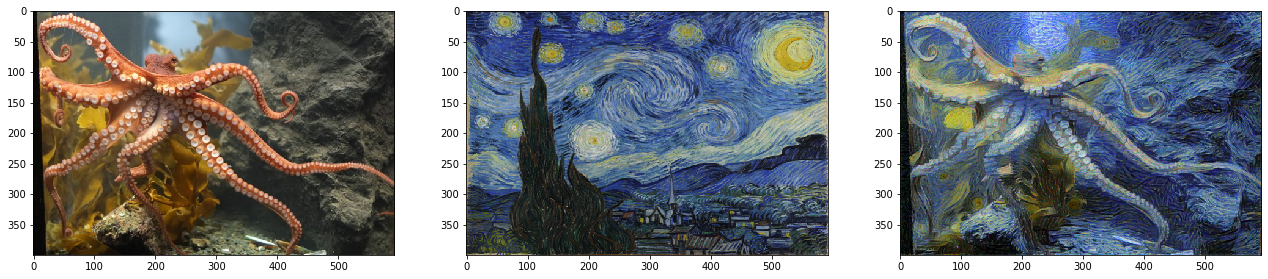

In [0]:
# display content and final, target image
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 12))
ax1.imshow(tensor_to_img(content))
ax2.imshow(tensor_to_img(style))
ax3.imshow(tensor_to_img(target))